# Numerical modeling workshop (Rijeka, 2022) — second day

TODO: heuristic derivation, connection with NS

Shallow-water equations:

\begin{aligned}
\frac{\partial h}{\partial t} &= -H\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}\right)\,\text,\\
\frac{\partial u}{\partial t} &= -g\frac{\partial h}{\partial x}
+fv\,\text,\\
\frac{\partial v}{\partial t} &= -g\frac{\partial h}{\partial y} - fu\,\text.
\end{aligned}

Solutions: gravity waves, inertia-gravity waves and geostrofic waves (stationary, degenerate solution).


TODO: detailed solution description and derivation


To discretize the equations, we use a grid of type C:
    
    h  u  h  u  h  u  h
    
    v     v     v     v
    
    h  u  h  u  h  u  h
    
    v     v     v     v
    
    h  u  h  u  h  u  h

TODO: different grid types, pros and cons of using this one

In theory: in bottom left, indices for $v$, $h$, i $u$ are $(0, 0)$ ($(1,1)$ in FORTRAN).

In current code: $(0,0)$ is in upper left corner.

Discretization:

\begin{aligned}
\frac{\partial h}{\partial t} = -H\left(\delta_x u+\delta_y v\right)\,\text,\\
\frac{\partial u}{\partial t} = -g\delta_xh-f\bar{v}^{xy}\,\text,\\
\frac{\partial v}{\partial t} = -g\delta_y h + f\bar{u}^{xy}\,\text.
\end{aligned}

\begin{aligned}
\frac{h^{n+1} - h^n}{\Delta t} = -H\left(\delta_xu + \delta_yv\right)^n\implies h^{n+1} = h^n-H \cdot \Delta t\cdot\left(\delta_xu + \delta_yv\right)^n
\end{aligned}

\begin{aligned}
\frac{u^{n+1} - u^n}{\Delta t} = -g\delta_xh + \left(f\bar{v}^{xy}\right)^n\implies u^{n+1} = u^n-g \cdot \Delta t\cdot\delta_x h^{n+1} + f\Delta t\left(\bar{v}^{xy}\right)^n
\end{aligned}

\begin{aligned}
v^{n+1} = v^n-g \cdot \Delta t\cdot\delta_y  h^{n+1} - f\Delta t\left(\bar{u}^{xy}\right)^n
\end{aligned}

Reminder:

\begin{aligned}
\text{forward difference: }& \left(\frac{\partial h}{\partial t}\right)_n = \frac{h^{n+1}-h^n}{\Delta t}\,,\\
\text{backward difference: }& \left(\frac{\partial h}{\partial t}\right)_n = \frac{h^n-h^{n-1}}{\Delta t}\,.
\end{aligned}

In current equations, all spatial differences are backward.

Regarding the temporal ones, schema in which we work with backward differences for one variable and forward differences for another is numerically more stable than the case of both of them being either forward or backward and thus one can choose a shorter time step.

TODO: discussion or references corroborating this fact

Finally, we turn the equation into indexed form based on the grid sketched above:

\begin{aligned}
h_{i,j}^{n+1} &= h_{i,j}^n - \frac{H\Delta t}{d}\left[\left(u_{i,j}^n - u_{i-1,j}^n\right) + \left(v_{i,j}^n - v_{i,j-1}^n\right)\right]\,,\\
u_{i,j}^{n+1} &= u_{i,j}^n - \Delta t\left[\frac gd\left(h_{i+1,j}^{n+1} - h_{i,j}^{n+1}\right) + \frac f4\left(v_{i,j}^n+v_{i+1,j}^n+v_{i+1,j-1}^n+v_{i,j-1}^n)\right)\right]\,,\\
v_{i,j}^{n+1} &= v_{i,j}^n - \Delta t\left[\frac gd\left(h_{i,j+1}^{n+1}-h_{i,j}^{n+1}\right) - \frac f4\left(u_{i,j}^n + u_{i,j+1}^n + u_{i-1,j+1}^n + u_{i-1,j}^n\right)\right]
\end{aligned}

## Source-sink experiment

### Preliminaries

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from copy import copy, deepcopy

In [2]:
Deltax = Deltay = d = 250000 # spatial step and the least distance between two cells in the grid
Deltat = 600 # time step
g = 9.81 # gravitational constant
f = 10 ** (-4) 
Lx = 23250000 # domain size in x direction
Ly = 21000000 # domain size in y direction
SSdistance = 1750000 # distance between source and sink
IM = round(Ly / Deltay) + 1 # number of grid points in y direction
JM = round(Lx / Deltax) + 1 # number of grid points in x direction
# NB: index i will correspond to y direction and index x will correspond to x direction
HN = 1000 # initial, unperturbed water height (over all domain)
T_steps = 10 # number of time steps
dh = round(2 * Deltat / 60) # water influx/outflux per time unit
Nmax = Deltat * T_steps # total time

In [3]:
def source_coordinates(lx, im, jm, deltax, ssdistance):
    j_left = round(((lx - ssdistance) / 2) / deltax)
    j_right = round(((lx - ssdistance) / 2) / deltax) + 1
    i_upper = round(im / 2)
    i_lower = round(im / 2) + 1
    return [i_upper, i_lower, j_left, j_right]
def sink_coordinates(lx, im, jm, deltax, ssdistance):
    j_left = round(((lx + ssdistance) / 2) / deltax)
    j_right = round(((lx + ssdistance) / 2) / deltax) + 1
    i_upper = round(im / 2)
    i_lower = round(im / 2) + 1
    return [i_upper, i_lower, j_left, j_right]

In [4]:
print(source_coordinates(Lx, IM, JM, Deltax, SSdistance))
print(sink_coordinates(Lx, IM, JM, Deltax, SSdistance))

[42, 43, 43, 44]
[42, 43, 50, 51]


In [5]:
# sink and source positioning in grid — we are given that the size of each is exactly 4 points
# and that their horizontal distance is 1750 km (while being centered as well)

i_source_upper, i_source_lower, j_source_left, j_source_right = source_coordinates(Lx, IM, JM, Deltax, SSdistance)
i_sink_upper, i_sink_lower, j_sink_left, j_sink_right = sink_coordinates(Lx, IM, JM, Deltax, SSdistance)

In [6]:
# initialization of variables
U = np.zeros((IM, JM), dtype=float)
V = np.zeros((IM, JM), dtype=float)
H = np.full((IM, JM), HN, dtype=float)
UF = np.zeros((IM, JM), dtype=float)
VF = np.zeros((IM, JM), dtype=float)
HF = np.full((IM, JM), HN, dtype=float)

n =  0


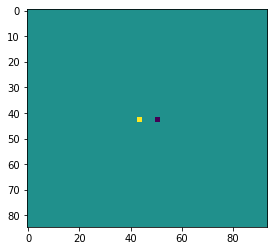

n =  50


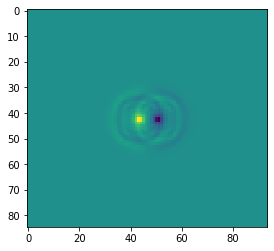

n =  100


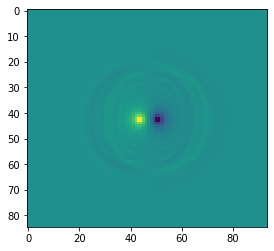

n =  150


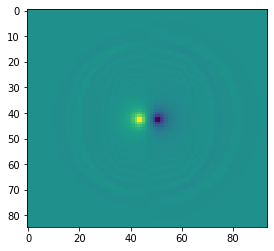

n =  200


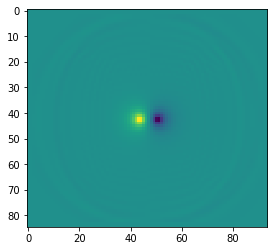

Wall time: 1min 27s


In [7]:
%%time
for n in range(Nmax):
    for i in range(2, IM - 2):
        for j in range(2, JM - 2):
            # TODO: implement array operations more efficiently
            # discretized differential equations
            HF[i, j] = H[i, j] - (HN * Deltat / d) * ((U[i, j] - U[i + 1, j]) + (V[i, j] - V[i, j + 1]))

            UF[i, j] = U[i, j] - Deltat *\
              ( (g / d) * (HF[i - 1, j] - HF[i, j])\
                + (f / 4) * (V[i, j] + V[i - 1, j] + V[i - 1, j + 1] + V[i, j + 1]) )

            VF[i, j] = V[i, j] - Deltat *\
            ( (g / d) * (HF[i, j - 1] - HF[i, j])\
              -(f / 4) * (U[i, j] + U[i, j - 1] + U[i + 1, j - 1] + U[i + 1, j]) )

            U = deepcopy(UF)
            V = deepcopy(VF)
            H = deepcopy(HF)
            
            # simulation of influx from source
            H[i_source_upper, j_source_left] += dh
            H[i_source_upper, j_source_right] += dh
            H[i_source_lower, j_source_left] += dh
            H[i_source_lower, j_source_right] += dh
            
            # simulation of outflux through sink
            H[i_sink_upper, j_sink_left] -= dh
            H[i_sink_upper, j_sink_right] -= dh
            H[i_sink_lower, j_sink_left] -= dh
            H[i_sink_lower, j_sink_right] -= dh
    if n % 50 == 0:
        print('n = ', n)
        plt.imshow(H, interpolation='none')
        plt.show()
    if n == 200:
        break

TODO: comments on graphs